# Benchmarking lung integration

In [18]:
import numpy as np
from anndata import AnnData
import scanpy as sc
import matplotlib.pyplot as plt

from scib_metrics.benchmark import Benchmarker

## Load and preprocess data

In [2]:
adata = sc.read(
    "data/lung_atlas.h5ad",
    backup_url="https://figshare.com/ndownloader/files/24539942",
)

In [3]:
adata

AnnData object with n_obs × n_vars = 32472 × 15148
    obs: 'dataset', 'location', 'nGene', 'nUMI', 'patientGroup', 'percent.mito', 'protocol', 'sanger_type', 'size_factors', 'sampling_method', 'batch', 'cell_type', 'donor'
    layers: 'counts'

In [4]:
sc.pp.highly_variable_genes(adata, n_top_genes=2000, flavor="cell_ranger", batch_key="batch")
sc.tl.pca(adata, n_comps=30)


/home/adam/miniconda3/envs/scib-metrics/lib/python3.10/site-packages/scanpy/preprocessing/_highly_variable_genes.py:478: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hvg = hvg.append(missing_hvg, ignore_index=True)
/home/adam/miniconda3/envs/scib-metrics/lib/python3.10/site-packages/scanpy/preprocessing/_highly_variable_genes.py:478: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hvg = hvg.append(missing_hvg, ignore_index=True)
/home/adam/miniconda3/envs/scib-metrics/lib/python3.10/site-packages/scanpy/preprocessing/_highly_variable_genes.py:478: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hvg = hvg.append(missing_hvg, ignore_index=True)
/home/adam/miniconda3/envs/scib-metrics/lib/python3.10/site-packages/scanpy/preproces

In [5]:
adata.obsm["Unintegrated"] = adata.obsm["X_pca"]

## Run methods

### Scanorama

In [6]:
%%capture
import scanorama
# List of adata per batch
batch_cats = adata.obs.batch.cat.categories
bdata = adata[:, adata.var.highly_variable].copy()
adata_list = [bdata[bdata.obs.batch == b] for b in batch_cats]
scanorama.integrate_scanpy(adata_list)

adata.obsm["Scanorama"] = np.zeros((adata.shape[0], adata_list[0].obsm["X_scanorama"].shape[1]))
for i, b in enumerate(bdata.obs.batch.cat.categories):
    adata.obsm["Scanorama"][adata.obs.batch == b] = adata_list[i].obsm["X_scanorama"]

### Liger

In [7]:
import pyliger
bdata = adata.copy()
bdata.X = bdata.layers["counts"]
bdata = bdata[:, bdata.var.highly_variable].copy()
# List of adata per batch
batch_cats = bdata.obs.batch.cat.categories
adata_list = [bdata[bdata.obs.batch == b].copy() for b in batch_cats]
for i, ad in enumerate(adata_list):
    ad.uns["sample_name"] = batch_cats[i]
    ad.uns['var_gene_idx'] = np.arange(bdata.n_vars)


liger_data = pyliger.create_liger(adata_list, remove_missing=False, make_sparse=False)
# Hack to make sure each method uses the same genes
liger_data.var_genes = bdata.var_names
pyliger.normalize(liger_data)
pyliger.scale_not_center(liger_data)
pyliger.optimize_ALS(liger_data, k=30)
pyliger.quantile_norm(liger_data)


adata.obsm["LIGER"] = np.zeros((adata.shape[0], liger_data.adata_list[0].obsm["H_norm"].shape[1]))
for i, b in enumerate(bdata.obs.batch.cat.categories):
    adata.obsm["LIGER"][adata.obs.batch == b] = liger_data.adata_list[i].obsm["H_norm"]

/home/adam/miniconda3/envs/scib-metrics/lib/python3.10/site-packages/pyliger/preprocessing/_scale.py:88: RuntimeWarning: divide by zero encountered in divide
100%|██████████| 30/30 [02:57<00:00,  5.90s/it]


### Harmony

In [8]:
from harmony import harmonize
Z = harmonize(adata.obsm["X_pca"], adata.obs, batch_key = "batch")
adata.obsm["Harmony"] = Z

	Initialization is completed.
	Completed 1 / 10 iteration(s).
	Completed 2 / 10 iteration(s).
	Completed 3 / 10 iteration(s).
	Completed 4 / 10 iteration(s).
	Completed 5 / 10 iteration(s).
	Completed 6 / 10 iteration(s).
	Completed 7 / 10 iteration(s).
	Completed 8 / 10 iteration(s).
	Completed 9 / 10 iteration(s).
	Completed 10 / 10 iteration(s).


### scVI

In [9]:
%%capture
import scvi
scvi.model.SCVI.setup_anndata(adata, layer="counts", batch_key="batch")
vae = scvi.model.SCVI(adata, gene_likelihood="nb", n_layers=2, n_latent=30)
vae.train()
adata.obsm["scVI"] = vae.get_latent_representation()

INFO:pytorch_lightning.utilities.seed:Global seed set to 0
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=246` reached.


## Perform the benchmark

In [10]:
bm = Benchmarker(
    adata,
    batch_key="batch",
    label_key="cell_type",
    embedding_obsm_keys=["Unintegrated", "Scanorama", "LIGER", "Harmony", "scVI"],
    n_jobs=6,
)
bm.benchmark()


Embeddings: 100%|██████████| 5/5 [01:45<00:00, 21.05s/it]


In [22]:
bm.get_results(min_max_scale=False).transpose()

Embedding,Unintegrated,Scanorama,LIGER,Harmony,scVI,Metric Type
Isolated labels,0.464394,0.504315,0.45722,0.46885,0.52464,Bio conservation
Silhouette label,0.585415,0.564586,0.542106,0.56432,0.535475,Bio conservation
cLISI,1.0,0.999625,0.985223,0.994074,0.99248,Bio conservation
Silhouette batch,0.855258,0.932109,0.850703,0.878664,0.898108,Batch correction
PCR comparison,0.0,0.25221,0.819954,0.547113,0.891582,Batch correction
iLISI,0.007811,0.064213,0.161164,0.128523,0.119051,Batch correction
KBET,0.24863,0.318194,0.500167,0.47236,0.373883,Batch correction
Batch correction,0.277925,0.391682,0.582997,0.506665,0.570656,Aggregate score
Bio conservation,0.68327,0.689508,0.661516,0.675748,0.684199,Aggregate score
Total,0.521132,0.570378,0.630109,0.608115,0.638781,Aggregate score


### Visualize the results

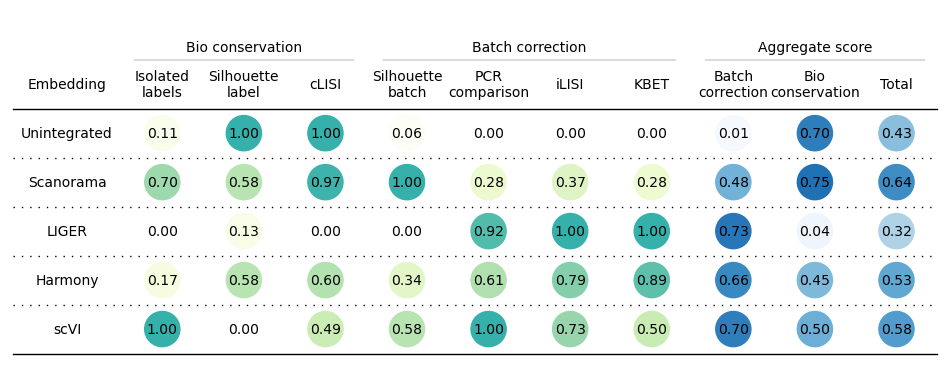

In [20]:
bm.plot_results_table()

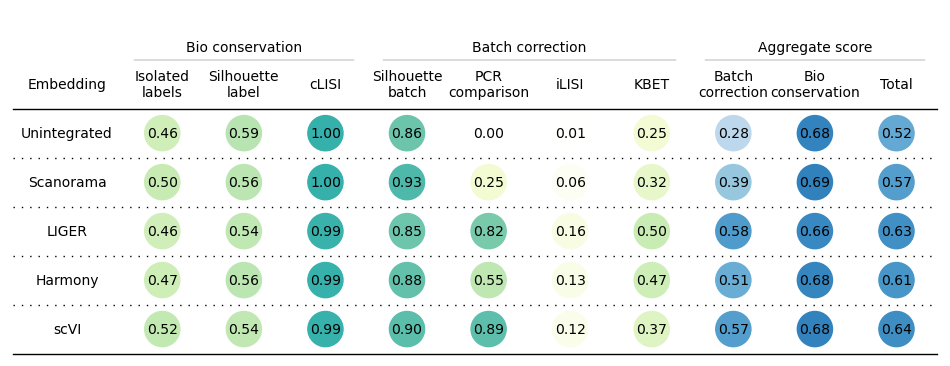

In [21]:
bm.plot_results_table(min_max_scale=False)